# <center> Projet </center>
## <center> Auto-encodeur Variationnel (VAE) </center>

---

### Auteurs
* PREAULT Rafael
* DEMANGE Noé

---

<img src="./figures/logo.jpg">

---

### M2-AMIS | Réseaux de Neurones et Classification
#### UFR des Sciences | Université de Versailles Saint-Quentin
#### Semestre 1 | Année Universitaire 2023 - 2024

---

## Table des Matières
- [Introduction](#introduction)
  - [Jeu de donnée](#jeu-de-donnee)
  - [Auto-encodeur variationnel (VAE)](#VAE)
- [0. Librairies](#librairies)
- [1. Chargement des données](#load-data)
- [2. Modèle et fonctions](#modele-fonctions)
- [3. VAE avec un espace latent de dimension 2](#VAE-D2)
- [4. VAE avec un espace latent de dimension 100](#VAE-D100)
- [5. Autres Résultats](#otherRes)
- [Conclusion](#conclusion)
- [Références](#references)
  - [Jeu de donnée](#dataset)
  - [Inspiration](#inspiration)  

## <a name="introduction"></a> Introduction

Dans ce projet, l'objectif est de se familiariser avec les réseaux de neurones. Pour cela nous avons choisi de travailler sur les auto-encodeurs variationnels.
Lors des [cours](https://github.com/JeremCab/ReseauxDeNeuronesM2AMIS/blob/main/Slides/13_VariationalAutoencoders.pdf) et des [TP](https://github.com/JeremCab/ReseauxDeNeuronesM2AMIS/blob/main/TP/13_VariationalAutoencoder.ipynb), nous avons pu avoir une première approche des auto-encodeurs et plus précisément des auto-encodeurs variationnels. Cette première approche était basée sur le jeu de donnée [MNIST](https://en.wikipedia.org/wiki/MNIST_database) ce qui nous a permis d'apprendre le fonctionnement de ces réseaux de neurones et leurs objectifs. Malgré cela, le jeu de donnée MNIST étant plutôt simple (image 28x28 en noir et blanc), nous avons eu envie d'essayer d'implémenter un VAE sur un autre jeu de donnée plus complexe afin de saisir la difficulté et le temps qu'il faut pour créer et entrainer un tel réseau de neurones. 

### <a name="jeu-de-donnee"></a>Jeu de donnée

Pour ce projet, nous avons choisi le jeu de donnée [Animal Faces-HQ (AFHQ)](#dataset).
Ce jeu de donnée contient 16 130 images, de têtes d'animaux, en couleurs, d'une résolution 512x512 pixels.
Il y a trois classes d'images, avec dans chaque classe environ 5000 images. Les trois classes sont chats, chiens et animaux sauvages et dans chaque classe il y a différentes espèces et/ou de races représentées. Nous utiliserons les images d'entrainement du jeu de donnée soit 14630 images, que nous auront reformatées dans une résolution 64x64 pixels, afin de réduire la taille des images et ainsi réduire la taille de nos réseaux de neurones dans le but d'améliorer la vitesse d'apprentissage. 
<img src="./figures/inbox_793761_afb6d1aa3be4c82e17a0d0b802436e82_afhq_dataset.jpg" widht="600px">

### <a name="VAE"></a>Auto-encodeur variationnel (VAE)

Le VAE est un type spécial d'auto-encodeur capable de générer de nouvelles instances d'une distribution latente apprise. Notre modèle VAE est composé des éléments suivants :

1. **Encodeur :** Capture les caractéristiques importantes des images.
2. **Espace Latent :** Représentation latente des caractéristiques apprises.
3. **Décodeur :** Recittructe l'image à partir de la représentation latente.

## <a name="librairies"/> 0. Librairies

In [5]:
import numpy as np #manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.

import torch #pour les réseaux de neurones
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt # pour l'affichage

On paramètre la librairie PyTorch.

In [6]:
torch.manual_seed(1) # Pour que le résultat soit toujours le même
torch.use_deterministic_algorithms(True) # Pour la reproductibilité des résultats
device = ""
if torch.cuda.is_available(): #Si on a un gpu utilise le gpu sinon utilise le cpu
    print("has gpu, using gpu")
    device = torch.device("cuda")
else:
    print("only cpu, using cpu")
    device = torch.device("cpu")

only cpu, using cpu


## <a name="load-data"/> 1. Chargement des données

On télécharge les données AFHQ. Nous utilisons seulement les données d'entrainements (train) car nous faisons un modèle par apprentissage non-supervisé (nous n'avons pas besoin de données de validation).

Paramètres :

In [7]:
image_size = 64 # Paramètre pour changer la taille des images
noc = 3 # le nombre indiquant qu'il y a 3 couleurs (RGB)
transform = transforms.Compose(
    [transforms.Resize((image_size,image_size)), transforms.ToTensor()]
)

Chargements des images depuis le jeu de donnée et affichages du nombre d'images.

In [8]:
train_set = datasets.ImageFolder(root="./data/afhq/train",transform=transform)
len(train_set)

14630

Affichage du format d'une image (exemple l'image 26). 0 permet de récupérer l'image tandis que 1 permet de connaître son label (chat, chien ou animal sauvage).

In [13]:
train_set[26][0].shape

torch.Size([3, 64, 64])

Affichage de l'image 26 et de son label. Label 0 = chat, 1 = chien et 2 = animal sauvage.

Text(0.5, 1.0, '0')

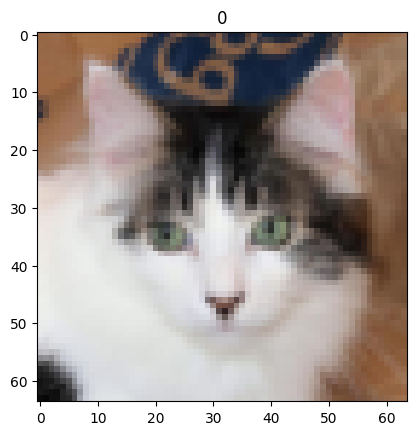

In [21]:
plt.imshow(train_set[26][0].squeeze().permute(1,2,0))
plt.title(train_set[26][1])

### Dataloader

Permet de préparer les données pour l'entraînement. On utilise le train_set et on forme des "batches" de 64 images. Shuffle permet d'indiquer qu'on va mélanger les données à chaque Epochs afin éviter l'overfitting. 

In [22]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)#, num_workers=2)

In [25]:
# data format
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape, labels.shape #64 images de taille 64x64 avec 3 valeurs pour chaque pixels et les 4 labels correspondants

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

Ensuite on vérifie que les images sont constituées par des valeurs de pixels entre 0 et 1.

In [26]:
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

## <a name="modele-fonctions"/> 2. Modèle et fonctions

### Modèle
La classe suivante implémente un **auto-encodeur variationnel (VAE)** composé de **couche de convolution**.

#### Encodeur (`self.encoder`)

L'encodeur utilise une séquence de couches convolutionnelles pour extraire les caractéristiques de l'entrée. Les couches convolutives sont suivies de fonctions d'activation ReLU. Nous avons fixés le nombre de channels de façon arbitraire.

#### Couches de sortie de l'encodeur (`self.z_mean` et `self.z_log_var`)

Ces couches linéaires génèrent les paramètres de la distribution latente (moyenne et logarithme de la variance) à partir des caractéristiques extraites par l'encodeur.

#### Décodeur (`self.decoder`)

Le décodeur utilise une séquence de couches de déconvolution (ou transposées) pour reconstruire l'entrée à partir de la distribution latente. Le nombre de channels est l'inverse que pour l'encodeur.

#### Méthode `sampling`

Cette méthode implémente l'échantillonnage stochastique dans l'espace latent en utilisant la méthode de reparamétrisation. Elle prend les paramètres de la distribution latente (moyenne et logarithme de la variance) et échantillonne un vecteur latent.

#### Méthode `forward`

La méthode `forward` implémente la propagation avant du modèle. Elle passe l'entrée à travers l'encodeur pour obtenir les caractéristiques latentes, obtient la moyenne (`mu`) et le logarithme de la variance (`log_sigma2`), échantillonne dans l'espace latent, puis passe le vecteur latent à travers le décodeur pour obtenir la reconstruction. Elle renvoie la reconstruction, la moyenne et le logarithme de la variance.


In [27]:
class VariationalAutoencoder_CNN(nn.Module):
    """Implements a CNN autoencoder"""

    def __init__(self, latent_dim=2):
        """constructor"""

        super().__init__()
        
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(noc, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            )

        self.z_mean = torch.nn.Linear(256*8*8, self.latent_dim)
        self.z_log_var = torch.nn.Linear(256*8*8, self.latent_dim)

        self.decoder_linear = nn.Linear(in_features=latent_dim, out_features=256*8*8)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, noc, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
            )

    def sampling(self, mean, log_var):
        "sampling from the latent space"
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mean)
        return z

    def forward(self, x):
         """forward pass"""
         x = self.encoder(x)
         x = x.view(x.size(0), -1)
         mu, log_sigma2 = self.z_mean(x), self.z_log_var(x)
         z = self.sampling(mu, log_sigma2)
         z = F.relu(self.decoder_linear(z))
         z = z.view(z.size(0), 256, 8, 8)
         x = self.decoder(z)
         return x, mu, log_sigma2

### Loss

On définit une fonction de perte (`loss_function`). Elle est extraite des TP. La perte combine deux composantes : la perte de reconstruction et la perte de divergence de Kullback-Leibler (KL).

#### Paramètres `alpha` et `beta`

Les paramètres `alpha` et `beta` sont utilisés pour pondérer les deux composantes de la perte. Dans le code actuel, ils sont définis à 1 chacun. Nous avons testé les paramètres du TP avec `alpha = 10` et `beta = 0.001`, ou encore `beta = 10`, mais n'ayant pas remarqué d'amélioration ou de changements significatifs, nous avons préféré les laisser à 1.

#### Fonction de Perte

La fonction `loss_function` prend quatre arguments :
- `recon_x` : la sortie reconstruite de l'autoencodeur,
- `x` : l'entrée originale,
- `mu` : la moyenne de la distribution latente,
- `log_var` : le logarithme de la variance de la distribution latente.

La perte de reconstruction (`BCE` pour Binary Cross Entropy) mesure la différence entre la sortie reconstruite et l'entrée originale. MSE (Mean Squared Error) est également implémentée et normalisée par la taille de l'échantillon. Nous utilisons BCE car cela semble mieux fonctionner avec cette fonction de perte mais une étude plus poussée pourrait être nécessaire afin de vérifier qu'utiliser MSE est effectivement moins efficace.

La perte de divergence de Kullback-Leibler (`KLD`) mesure la différence entre la distribution latente apprise par le modèle et une distribution normale standard.

La fonction de perte totale est une combinaison linéaire de ces deux composantes, où les paramètres `alpha` et `beta` sont utilisés pour ajuster l'importance relative des termes de perte.


In [28]:
# losses not normalized hence 
#alpha, beta = 10., 0.001
alpha, beta = 1, 1

def loss_function(recon_x, x, mu, log_var):
    "MSE/BCE + KL loss"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, noc, image_size, image_size), reduction='sum')
    #MSE = torch.norm( (recon_x - x.view(-1, noc, image_size, image_size)) ) / x.shape[0]
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return beta*KLD +alpha*BCE #MSE

### Entraînement

On définie une fonction `training_VAE` pour effectuer la boucle d'entraînement de l'autoencodeur variationnel (VAE). Cette boucle itère sur plusieurs époques (`num_epochs`) et met à jour les poids du modèle en fonction de la fonction de perte définie précédemment.

#### Paramètres de la Fonction

- `model`: Le modèle de VAE à entraîner.
- `num_epochs`: Le nombre d'époques pour lesquelles la boucle d'entraînement sera exécutée (par défaut à 24).

#### Initialisation des Variables

Une liste `outputs_l` est initialisée pour stocker les résultats de chaque époque.

#### Boucle d'Entraînement

La boucle d'entraînement itère sur chaque époque. Pour chaque époque, elle itère sur les batches (`train_loader`) du jeu de données d'entraînement.

Pour chaque batches, le modèle VAE est utilisé pour générer des sorties (`outputs`), et la fonction de perte est calculée en utilisant la fonction définie précédemment (`loss_function`).

Les gradients sont ensuite réinitialisés, la rétropropagation est effectuée, et les poids du modèle sont mis à jour avec l'optimiseur (`optimizer`).

#### Calcul de la Perte d'Entraînement

La perte d'entraînement moyenne pour l'époque est calculée à partir des pertes individuelles des batches.

#### Affichage des Résultats

Toutes les 10 époques, les résultats de chaque époque, tels que le numéro de l'époque (`epoch`), la perte d'entraînement moyenne (`train_loss`), sont affichés.

#### Stockage des Résultats

Les résultats de chaque époque, y compris les entrées, les sorties du modèle, et la perte, sont stockés dans la liste `outputs_l`.

#### Résultats Retournés

La fonction retourne la liste `outputs_l`.


In [29]:
# training
def training_VAE(model,  num_epochs=24):
    """training loop"""
    outputs_l = []

    for epoch in range(num_epochs):

        train_loss = []

        for (inputs, _) in train_loader:

            #inputs = inputs.reshape(-1, image_size*image_size) # reshape data image_size*image_size
            
            outputs, mu, log_var = model(inputs)
            loss = loss_function(outputs, inputs, mu, log_var)
                
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = torch.mean(torch.tensor(train_loss)).item()

        if(epoch % 10 == 0):
            print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

        outputs_l.append((epoch, inputs, outputs, train_loss))
        
    return outputs_l

### Affichage des résultats

La fonction `plot_training_loss` est génére un graphique de la perte au fil des époques pendant l'entraînement du modèle VAE.

#### Paramètres
- `outputs_l`: Liste des informations d'entraînement générées pendant la fonction d'entraînement.
- `y_label`: Étiquette de l'axe y du graphique, indiquant ce qui est mesuré (par défaut à "BCE + KL loss" pour la perte de reconstruction binaire).
- `filename`: Nom du fichier dans lequel sauvegarder le graphique.

#### Fonctionnement
- La fonction crée une figure avec une taille spécifiée.
- Elle extrait les données pertinentes de la liste `outputs_l`, à savoir le numéro d'époque (`epochs`) et la perte (`train_loss`).
- Elle trace la courbe de la perte en fonction du nombre d'époques.


In [31]:
def plot_training_loss(outputs_l, y_label = "BCE + KL loss", filename=""):
    "plot the training loss"
    
    plt.figure(figsize=(5, 3))

    epochs = [x[0] for x in outputs_l]
    train_loss = [x[3] for x in outputs_l]

    plt.plot(epochs, train_loss, label="training loss")
    plt.xlabel("epochs")
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(filename, format="pdf", bbox_inches="tight")

La fonction `plot_training_samples` génére un graphique présentant les entrées et les sorties reconstruites pendant l'entraînement d'un modèle VAE.

#### Paramètres
- `outputs_l`: Liste des informations d'entraînement générées pendant la fonction d'entraînement.
- `filename`: Nom du fichier dans lequel sauvegarder le graphique.
- `num_epochs`: Nombre total d'époques d'entraînement.

#### Fonctionnement
- La fonction crée une figure composée de plusieurs sous-images arrangés en 6 lignes et 10 colonnes.
- Trois époques d'entraînement (le début, le milieu et la fin) sont sélectionnées pour être affichées.
- Les entrées originales sont affichées sur la première ligne, et les sorties reconstruites par le modèle VAE sont affichées sur la deuxième ligne.


In [32]:
def plot_training_samples(outputs_l, filename="", num_epochs=24):
    "plot inputs and reconstructed inputs during training"

    fig, axs = plt.subplots(6, 10, 
                            figsize=(10, 7), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

        inputs = outputs_l[k][1].detach()#.numpy()
        outputs = outputs_l[k][2].detach()#.numpy()

        axs[2*i, 0].set_title(f"Epoch {k+1}")
        axs[2*i, 0].set_ylabel("Inputs")

        for j, item in enumerate(inputs):

            if j >= 10: break
            axs[2*i, j].imshow(item.squeeze().permute(1,2,0))
            axs[2*i, j].set_xticks([])
            axs[2*i, j].set_yticks([])

        axs[2*i + 1, 0].set_ylabel("Outputs")
        for j, item in enumerate(outputs):
            
            if j >= 10: break
            axs[2*i + 1, j].imshow(item.squeeze().permute(1,2,0))
            axs[2*i + 1, j].set_xticks([])
            axs[2*i + 1, j].set_yticks([])

    fig.savefig(filename, format="pdf", bbox_inches="tight")

## <a name="VAE-D2"/> 3. VAE avec un espace latent de dimension 2

### Modèle

Instanciation d'un **VAE** et d'un **optimizer (`torch.optim.Adam`)** avec un learning rate `lr=1e-3`.

In [40]:
# instanciation
modelVAEd2 = VariationalAutoencoder_CNN(latent_dim=2)

optimizer = torch.optim.Adam(modelVAEd2.parameters(), 
                             lr=1e-3)
modelVAEd2.eval()

VariationalAutoencoder_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (z_mean): Linear(in_features=16384, out_features=2, bias=True)
  (z_log_var): Linear(in_features=16384, out_features=2, bias=True)
  (decoder_linear): Linear(in_features=2, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

### Entraînement

Entraînement du modèle sur 24 époques.

In [34]:
outputs_l = training_VAE(modelVAEd2,  num_epochs=24)

Epoch:1 	 Train loss: 521477.3438
Epoch:11 	 Train loss: 508758.9375
Epoch:21 	 Train loss: 508475.6562


### Résultats

Affichage de la perte, cela permet de confirmer que le modèle a été assez entraîné.

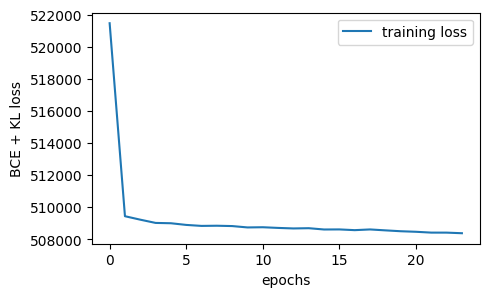

In [36]:
plot_training_loss(outputs_l, y_label="BCE + KL loss", filename="figures/VAE_linear_d2_loss_101_BCEKL.pdf")

On voit ici que le modèle pourrait être plus entraîné mais nous avons décidé de ne pas trop l'entraîné car avec un espace latent de dimension 2 notre VAE ne fonctionne pas très bien.

Affichage des entrées et de leur reconstructions par le modèle à différentes époques.

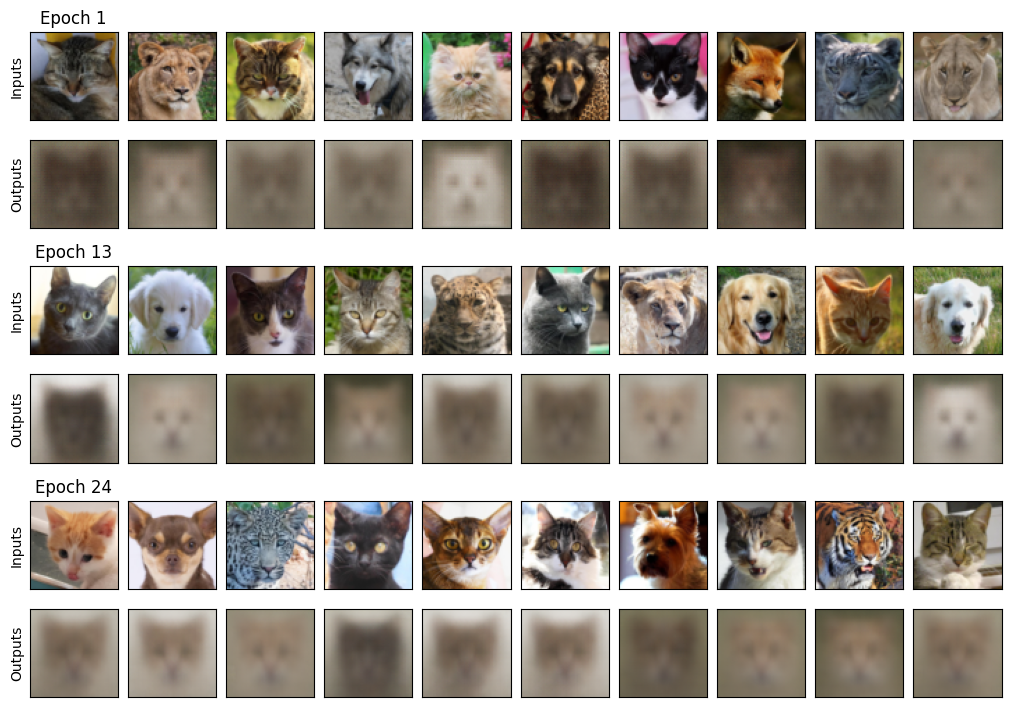

In [37]:
plot_training_samples(outputs_l, filename="figures/VAE_linear_d2_101_BCEKL.pdf", num_epochs=24)

On voit que les reconstructions n'évoluent pas vraiment plus le modèle apprend.

### Visualisation de l'espace latent 2D

Avec le code suivant l'objectif est de visualiser 1024 images encoder dans l'espace latent 2D.
Si le modèle fonctionne bien on espère voir les trois classes centrées vers le milieu de l'espace et avec les points des images d'une même classe côté à côte.

In [38]:
def visualize_2d_latent_space(model, filename):
    
    model.eval()
    #encoder = model.encoder.eval()

    nb_batches = 16
    data_d = {"images" : [], "labels" : []}

    for i, batch in enumerate(train_loader):

        with torch.no_grad():

            images, labels = batch[0], batch[1]
            images = images.reshape(-1, noc, image_size, image_size)
            
            # encode inputs and sample in the latent space
            x, mu, log_sigma2 = model(images)
            #x = encoder(images)
            #mu, log_sigma2 = model.z_mean(x), model.z_log_var(x)
            latent_points = model.sampling(mu, log_sigma2)

            if i == nb_batches:
                break
            else:
                data_d["images"].extend(latent_points)
                data_d["labels"].extend(labels)
    
    nb_images = len(data_d["images"])
    nb_labels = len(data_d["labels"])

    print(f"Nb of encoded images: {nb_images}")
    print(f"Nb of labels: {nb_labels}")

    latent_images = torch.cat(data_d["images"], axis=0).reshape(-1, 2)
    labels = torch.tensor(data_d["labels"])

    x = latent_images[:, 0]
    y = latent_images[:, 1]
    
    print(x.shape, y.shape)
    
    plt.figure(figsize=(10, 7))
    plt.title("Latent space", size=14)

    cm = plt.colormaps.get_cmap('rainbow')

    plt.scatter(x, y, c=labels, alpha=0.6, cmap=cm)

    cbar = plt.colorbar()
    #cbar.set_ticks(np.linspace(0.4, 8.6, 3))
    #cbar.set_ticklabels(list(range(0, 3)))

    plt.savefig(filename, format="pdf", bbox_inches="tight")
    # plt.show()

Nb of encoded images: 1024
Nb of labels: 1024
torch.Size([1024]) torch.Size([1024])


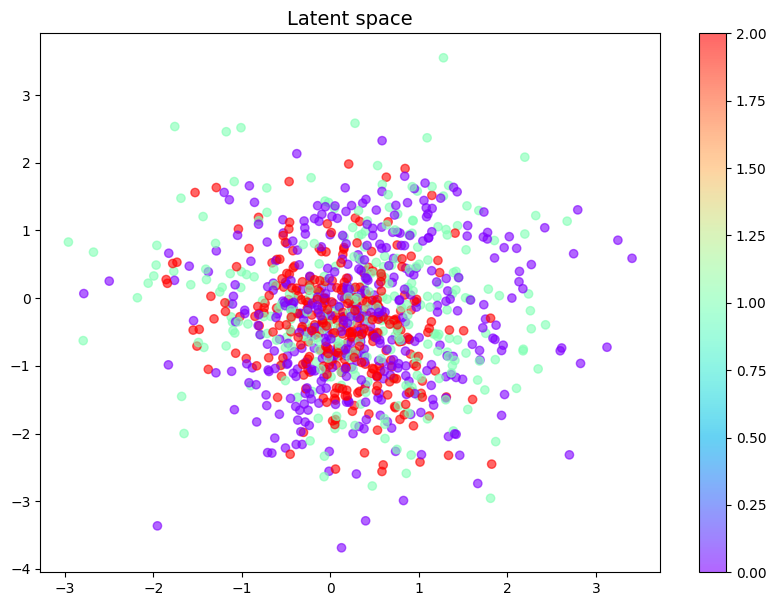

In [39]:
visualize_2d_latent_space(modelVAEd2, "figures/VAE_linear_d2_latent_space_101_MSEKL.pdf")

Avec cette visualisation, nous voyons que nos 3 classes sont mélangées dans l'espace latent et ne sont pas distinctes les unes des autres. Le modèle avec un espace latent 2D n'est donc pas adéquat. Si on veut générer des images à partir de cet espace, nous auront du mal à choisir la classe que l'on souhaite avoir.

## <a name="VAE-D100"/> 4. VAE avec un espace latent de dimension 100

Nous avons vu qu'avec un espace latent à 2 dimensions notre modèle ne fonctionnait pas très bien. Nous avons testé différents nombre de dimension supérieur à 2 et nous avons fini par choisir 100 dimensions. Nous avons jugé que ce nombre n'était pas trop grand comparé à la taille d'une image (64x64 = 4096), et il semble être assez grand pour contenir assez d'informations.

### Modèle

In [41]:
modelVAEd100 = VariationalAutoencoder_CNN(latent_dim=100)

In [42]:
optimizer = torch.optim.Adam(modelVAEd100.parameters(), 
                             lr=1e-3)

In [43]:
modelVAEd100.eval()

VariationalAutoencoder_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (z_mean): Linear(in_features=16384, out_features=100, bias=True)
  (z_log_var): Linear(in_features=16384, out_features=100, bias=True)
  (decoder_linear): Linear(in_features=100, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

### Entraînement

Entraînement du modèle sur 256 epochs.

In [20]:
outputs_l = training_VAE(modelVAEd100,  num_epochs=256)

Epoch:1 	 Train loss: 498167.5000
Epoch:2 	 Train loss: 476899.9062
Epoch:3 	 Train loss: 471379.3125
Epoch:4 	 Train loss: 468843.6875
Epoch:5 	 Train loss: 467493.2500
Epoch:6 	 Train loss: 466713.5000
Epoch:7 	 Train loss: 466064.9062
Epoch:8 	 Train loss: 465563.1875
Epoch:9 	 Train loss: 465263.9375
Epoch:10 	 Train loss: 464954.9375
Epoch:11 	 Train loss: 464585.5625
Epoch:12 	 Train loss: 464281.7500
Epoch:13 	 Train loss: 464027.3125
Epoch:14 	 Train loss: 463870.9062
Epoch:15 	 Train loss: 463693.4062
Epoch:16 	 Train loss: 463448.9375
Epoch:17 	 Train loss: 463224.9688
Epoch:18 	 Train loss: 463231.7812
Epoch:19 	 Train loss: 462984.7812
Epoch:20 	 Train loss: 462891.5312
Epoch:21 	 Train loss: 462813.6875
Epoch:22 	 Train loss: 462719.7812
Epoch:23 	 Train loss: 462519.9375
Epoch:24 	 Train loss: 462385.2812
Epoch:25 	 Train loss: 462293.6250
Epoch:26 	 Train loss: 462198.5000
Epoch:27 	 Train loss: 462145.5938
Epoch:28 	 Train loss: 462046.1875
Epoch:29 	 Train loss: 461944

### Résultats

Affichage de la perte, cela permet de confirmer que le modèle a été assez entraîné.

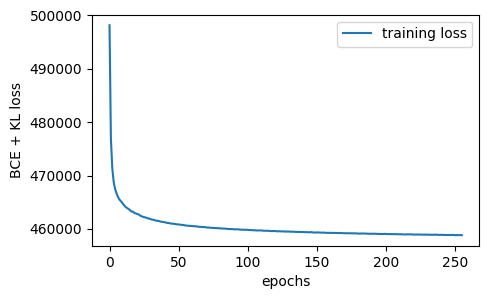

In [21]:
plot_training_loss(outputs_l, y_label="BCE + KL loss", filename="figures/VAE_linear_d100_loss.pdf")

Comparé au modèle précédent, on remarque une nette amélioration dans l'entraînement du modèle, avec 256 epochs. Néanmoins, nous pensons qu'il faudrait l'entraîner davantage. Le problème qui se pose étant que nos ordinateurs ne sont pas assez puissants pour entraîner plus rapidement, et nous ne pouvons pas les laisser tourner plusieurs jours.

Affichage des entrées et de leur reconstructions par le modèle à différentes époques.

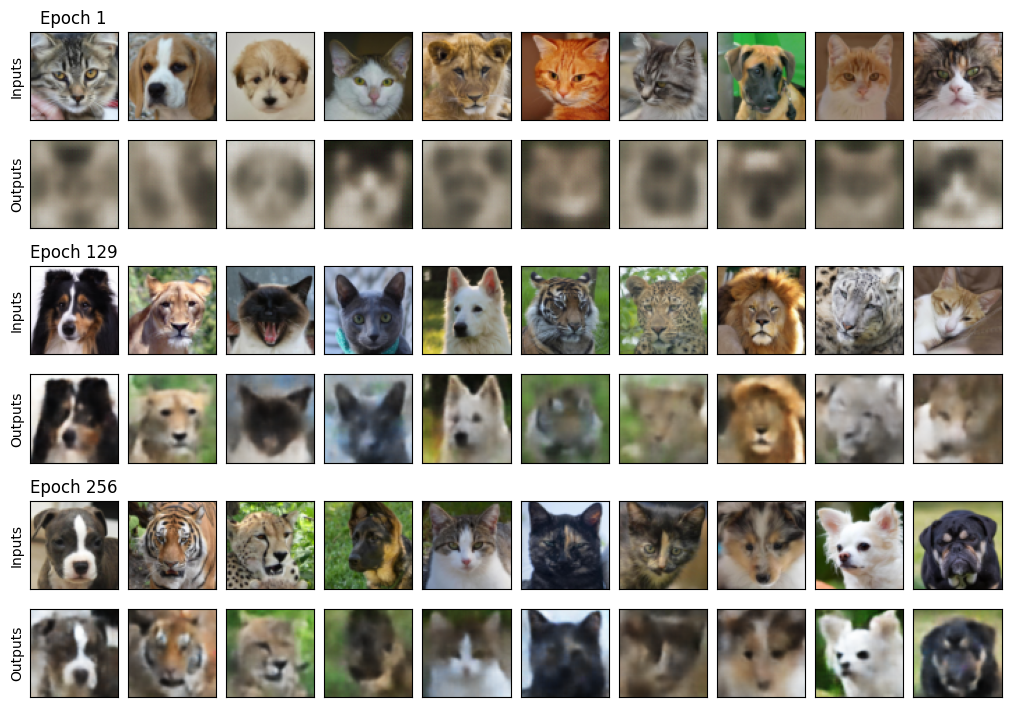

In [22]:
plot_training_samples(outputs_l, filename="figures/VAE_linear_d100_BCEKL.pdf", num_epochs=256)

On voit ici que les reconstructions s'améliore au fil de l'apprentissage du modèle. Au bout de l'entaînement, on voit que les images reconstruite ressemblent sensiblement à l'image d'entrée, mais avec néanmoins une nettetée moins bonne. Cela confirme qu'il aurait fallu entraîner le modèle plus longtemps.

### Capacité de génération du décodeur

#### Génération de Données : Échantillonnage Normal depuis l'Espace Latent + Décodage

Dans ce code, des données sont générées en échantillonnant aléatoirement depuis l'espace latent du modèle VAE avec un espace latent de 100 dimensions. Les échantillons générés sont ensuite décodés pour obtenir des données générées.

#### Paramètres
- `d`: Dimension de l'espace latent (ici, 100).
- `samples_normal`: Échantillons générés aléatoirement depuis une distribution normale multivariée avec une moyenne nulle et une matrice de covariance identité. Ces échantillons sont stockés dans un tenseur PyTorch.
- `modelVAEd100`: Modèle VAE avec une dimension latente de 100.

#### Étapes
1. **Échantillonnage depuis l'Espace Latent :**
   - Des échantillons aléatoires sont générés en utilisant `np.random.multivariate_normal` pour créer une distribution normale multivariée.
   - Les échantillons sont convertis en un tenseur PyTorch (`torch.tensor(samples_normal).float()`).

2. **Décodage des Échantillons :**
   - Les échantillons générés sont passés à travers la partie décodeur du modèle VAE (`modelVAEd100`).
   - La première couche (linéaire) du décodeur est activée par la fonction ReLU (`F.relu`).
   - La forme du tenseur résultant est ajustée pour correspondre à celle attendue par le décodeur du modèle (`samples_normal.view(samples_normal.size(0), 256, 8, 8)`).
   - Les échantillons générés sont obtenus en appliquant le décodeur (`modelVAEd20.decoder(samples_normal)`).

3. **Forme Finale des Échantillons Générés :**
   - La forme finale des échantillons générés est affichée à l'aide de la propriété `generated_samples.shape`.


In [25]:
d = 100
samples_normal = np.random.multivariate_normal(mean=torch.zeros(d),
                                               cov=torch.eye(d),
                                               size=100)
samples_normal = torch.tensor(samples_normal).float()
# Decode samples
with torch.no_grad():
    samples_normal = F.relu(modelVAEd100.decoder_linear(samples_normal))
    samples_normal = samples_normal.view(samples_normal.size(0), 256, 8, 8)
    generated_samples = modelVAEd20.decoder(samples_normal)#.reshape(-1, noc, image_size, image_size)

generated_samples.shape

torch.Size([100, 3, 64, 64])

#### Fonction d'affichage des images Générées
#### Paramètres
- `generated_samples`: Tenseur représentant les échantillons générés par le modèle VAE.
- `filename`: Nom du fichier dans lequel sauvegarder le graphique.

#### Fonctionnement
- La fonction crée une figure composée de plusieurs sous-images arrangés en 10 lignes et 10 colonnes.
- Les échantillons générés sont organisés en groupes de 10, et chaque groupe est affiché sur une ligne de la figure.
- Les images sont extraites du tenseur `generated_samples`.


In [26]:
def plot_generated_samples(generated_samples, filename=""):
    "plot generated samples"
    
    fig, axs = plt.subplots(10, 10, 
                            figsize=(10, 10), 
                            layout="constrained",
                            gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    for i in range(10):

        samples = generated_samples[10*i:10*i+10, :, :]

        for j in range(10):

            axs[i, j].imshow(samples[j, :, :].squeeze().permute(1,2,0))
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])


    fig.savefig(filename, format="pdf", bbox_inches="tight")

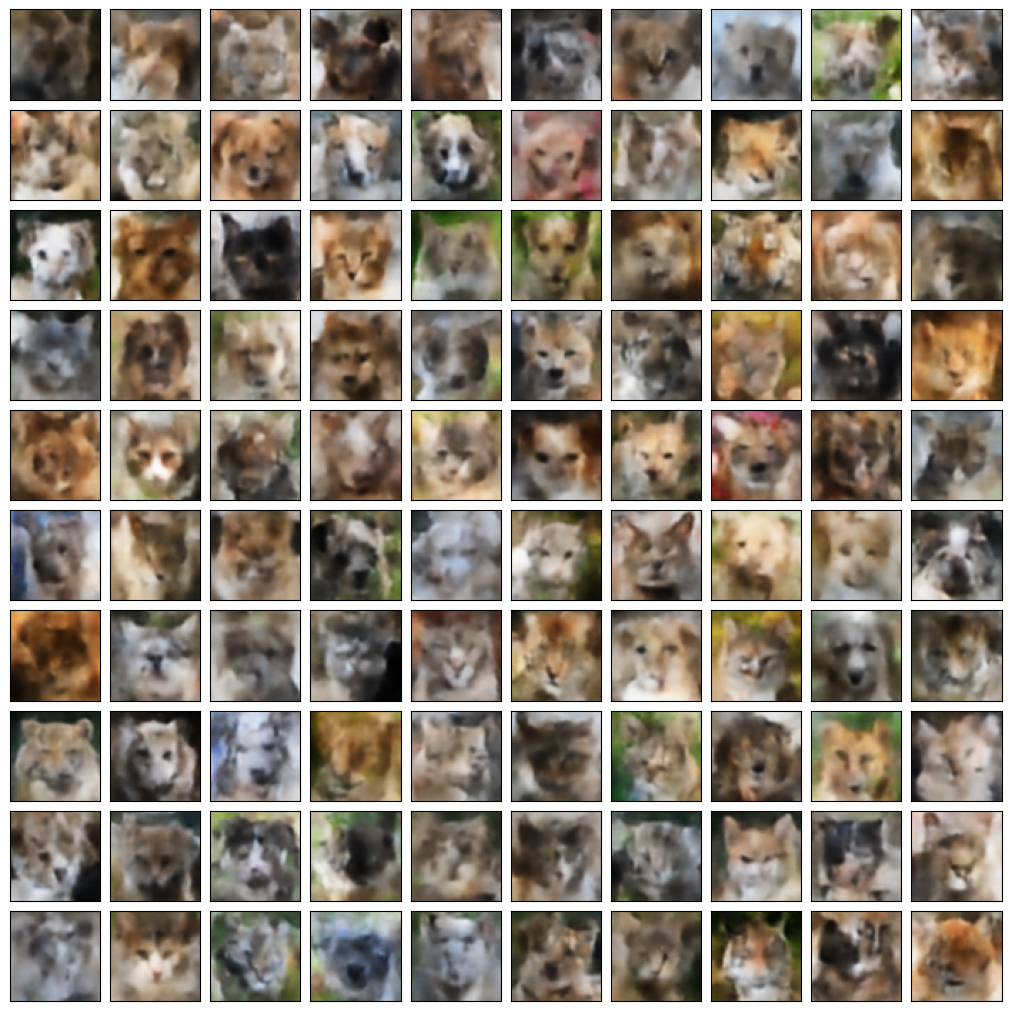

In [27]:
plot_generated_samples(generated_samples, filename="figures/VAE_generator_d100_BCEKL.pdf")

En générant les images, on remarque une certaines cohérence vis-à-vis des couleurs présentes, similaires à celles de jeu de donnée. De plus, on peut reconnaître des visages dans les images générées (yeux et bouches). Cependant, il est impossible (ou difficile) de reconnaître ou d'avoir une idée de l'animal qui a été généré. À partir de ces images, on peut déduire que les classes dans l'espace latent se chevauchent. 

## <a name="otherRes"/> Autres Résultats

N'ayant pas été très convaincu par les résultats présentés précédemment, nous avons décidé d'entraîner notre modèle en variant la dimension de l'espace latent ainsi que le nombre d'epochs.

<h2>Espace latent de dimension 1024 sur 60 epochs:</h2> 
<h3>Images générées : </h3> 

<img src="./figures/outputImage1024.png">
<br>

<h3>Fonction de loss : </h3> 
<img src="./figures/outputLossTD1024.png">

<h2>Espace latent de dimension 512 sur 60 epochs:</h2> 
<h3>Images générées : </h3> 

<img src="./figures/outputImage512.png">
<br>

<h3>Fonction de loss : </h3> 
<img src="./figures/outputLoss512.png">

<h2>Espace latent de dimension 256 sur 60 epochs:</h2> 
<h3>Images générées : </h3> 

<img src="./figures/outputImage256.png">
<br>

<h3>Fonction de loss : </h3> 
<img src="./figures/outputLoss256.png">

<h2>Espace latent de dimension 100 sur 512 epochs:</h2> 
<h3>Images générées : </h3> 

<img src="./figures/outputImage.png">
<br>

<h3>Fonction de loss : </h3> 
<img src="./figures/outputLoss.png">


Nous remarquons qu'augmenter la dimension de l'espace latent au delà de 100 ne semble pas améliorer les résultats obtenus, cela semble au contraire ralentir la convergence de la fonction de Loss (notamment pour une dimension égale à 1024). En revanche, lorsque l'on augmente le nombre d'epochs d'entraînement, nous obtenons des résultats qui nous semblent meilleurs, bien que nous n'en soyons pas totalement satisfait. La fonction de Loss quant à elle, semble converger vers une valeur aux alentours des 46 000. L'éxécution de notre modèle sur 512 epochs avec un espace latent de dimension 100 à durée environ 10h avec un processeur allant de 2,5 à 4,5 GHz, et une mémoire vive de 16Go. Peut-être qu'un entraînement sur un nombre d'epochs encore plus conséquent permettrait l'obtention de meilleurs résultats. Sinon, peut-être que rajouter un certains nombre de couches à notre modèle permettrait d'accélérer sa vitesse de convergence.  




## <a name="conclusion"/> Conclusion

Pour conclure, ce projet nous a permis d'apprendre comment faire un VAE et d'apprendre à gérer les dimensions des images. Il nous a permis de voir la difficulté pour créer un bon modèle et du temps qu'il faut pour l'entraîner. Nous n'avons pas réussi à créer un modèle qui soit convaincant. 

On pourrait espérer améliorer ce modèle en changeant par exemple le nombre de couche du modèle, ou encore en changeant les pondérations des pertes. 
Un autre paramètre qui pourrait être changé est la taille de l'espace latent mais il faudrait faire une étude plus poussé pour bien choisir cette valeur.
Pour finir, le jeu de donnée qu'on a choisi ne contient peut-être pas assez d'images pour permettre un bon entraînement. De plus, certaines images du jeu de donnée semblent ne pas représenter des visages d'animaux comme l'image suivante et on pu empêcher un bon apprentissage du modèle. Malheureusement, nous n'avons pas fait nous même le jeu de donnée, et nous n'avons pas pu nous pencher avec précision sur les images contenues, afin de réaliser un tri et de ne garder que celles qui nous intéressaient.  

Text(0.5, 1.0, '2')

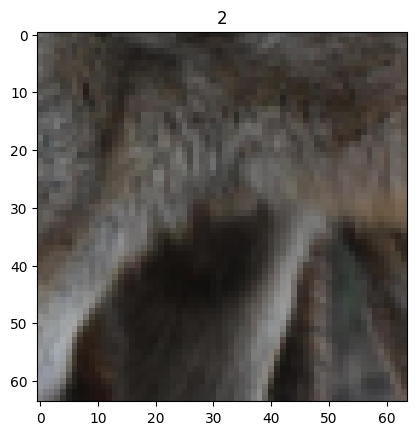

In [44]:
plt.imshow(train_set[13000][0].squeeze().permute(1,2,0))
plt.title(train_set[13000][1])

## <a name="references"/> Références
### <a name="dataset"/> Jeu de donnée : 
StarGAN v2: Diverse Image Synthesis for Multiple Domains, Yunjey Choi and Youngjung Uh and Jaejun Yoo and Jung-Woo Ha, Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 2020
[Animal-faces](https://www.kaggle.com/datasets/andrewmvd/animal-faces)
### <a name="inspiration"/> Inspiration :
- TP 13_VariationalAutoencoder
- [Animal image generator DCGAN](https://www.kaggle.com/code/jclohjc/animal-image-generator-dcgan)
- ChatGPT 3.5
